In [ ]:
! pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='binary_ct.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('binary_ct.zip')

In [ ]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
!unzip binary_ct.zip

Streaming output truncated to the last 5000 lines.
  inflating: binary_ct/train/covid/pCT1006.jpg  
  inflating: binary_ct/train/covid/pCT1009.jpg  
  inflating: binary_ct/train/covid/pCT1012.jpg  
  inflating: binary_ct/train/covid/pCT1013.jpg  
  inflating: binary_ct/train/covid/pCT1015.jpg  
  inflating: binary_ct/train/covid/pCT1018.jpg  
  inflating: binary_ct/train/covid/pCT1019.jpg  
  inflating: binary_ct/train/covid/pCT1022.jpg  
  inflating: binary_ct/train/covid/pCT1024.jpg  
  inflating: binary_ct/train/covid/pCT1025.jpg  
  inflating: binary_ct/train/covid/pCT1030.jpg  
  inflating: binary_ct/train/covid/pCT1044.jpg  
  inflating: binary_ct/train/covid/pCT1046.jpg  
  inflating: binary_ct/train/covid/pCT1048.jpg  
  inflating: binary_ct/train/covid/pCT1050.jpg  
  inflating: binary_ct/train/covid/pCT1051.jpg  
  inflating: binary_ct/train/covid/pCT1053.jpg  
  inflating: binary_ct/train/covid/pCT1056.jpg  
  inflating: binary_ct/train/covid/pCT1059.jpg  
  inflating: binar

In [ ]:
train_path = "/content/binary_ct/train"
test_path = "/content/binary_ct/test"

In [ ]:
PATH = '/content/binary_x_ray'
os.listdir(PATH)
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')
train_normal_dir = os.path.join(train_dir,
                                'normal')
train_covid19_dir = os.path.join(train_dir,
                               'covid-19')

test_normal_dir = os.path.join(test_dir,
                               'normal')
test_covid19_dir = os.path.join(test_dir,
                              'covid-19')
len(os.listdir(train_normal_dir))


1500

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


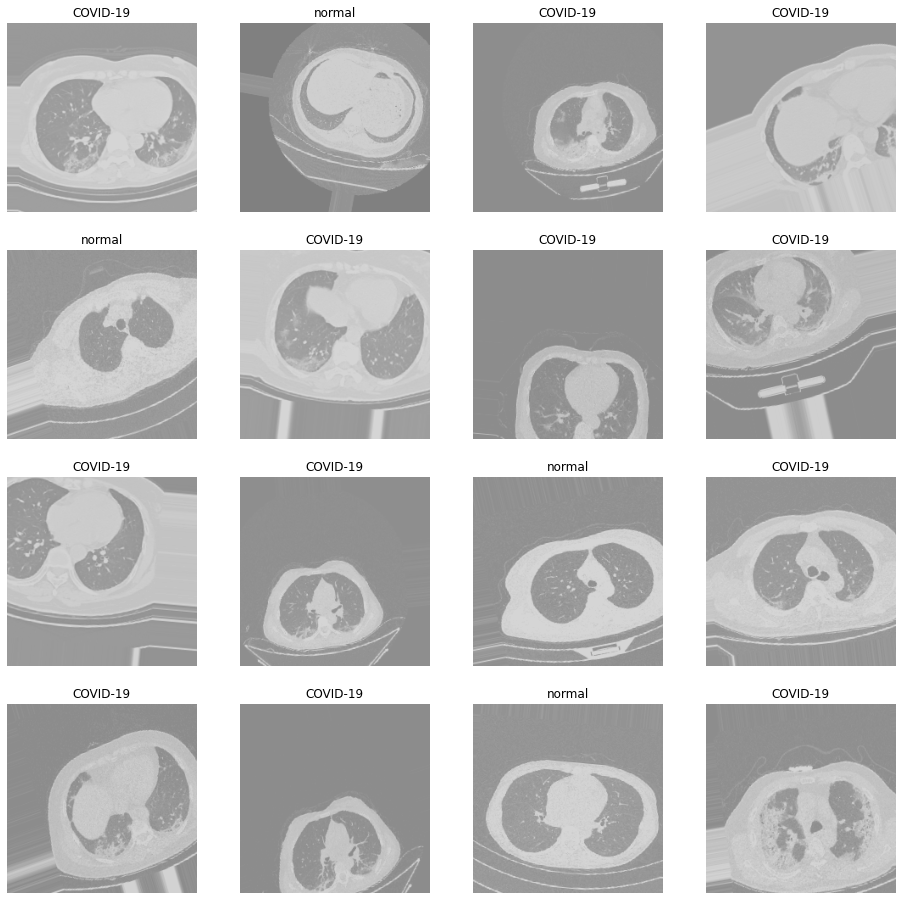

In [ ]:
all_labels = ['COVID-19','normal']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = False,
 channel_shift_range = 20,
 horizontal_flip = False ,
 vertical_flip = False ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from keras.applications import VGG16
vggModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
epochs= 100

BS = 16

In [ ]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 318//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 48//BS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
19/19 [==============================] - 14s 347ms/step - loss: 0.9999 - accuracy: 0.5735 - val_loss: 3.4373 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 6s 329ms/step - loss: 0.3146 - accuracy: 0.8696 - val_loss: 3.0856 - val_accuracy: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 6s 321ms/step - loss: 0.2035 - accuracy: 0.9157 - val_loss: 6.7670 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 6s 327ms/step - loss: 0.2634 - accuracy: 0.8820 - val_loss: 4.3578 - val_accuracy: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 6s 327ms/step - loss: 0.1541 - accuracy: 0.9472 - val_loss: 4.1396 - val_accuracy: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 6s 328ms/step - loss: 0.1563 - accuracy: 0.9441 - val_loss: 4.9916 - val_accuracy: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 6s 331ms/step - loss: 0.1465 - accuracy: 0.9436 - val_loss: 7.40

In [ ]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

 8/62 [==>...........................] - ETA: 0s - loss: 3.4374 - accuracy: 0.6250

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


62/62 [==============================] - 1s 12ms/step - loss: 1.0169 - accuracy: 0.9194


In [ ]:
from keras.callbacks import History 
history = History()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()



plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()

KeyError: ignored

 1/30 [>.............................] - ETA: 4s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



30/30 [==============================] - 0s 12ms/step
Predictions finished
prob:[4.2885767e-06 9.9999571e-01]
covid/pCT1.jpg


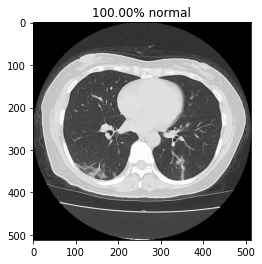

prob:[4.6548794e-06 9.9999535e-01]
covid/pCT10.jpg


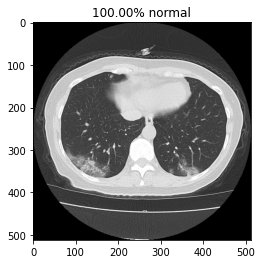

prob:[0.09871494 0.90128505]
covid/pCT100.jpg


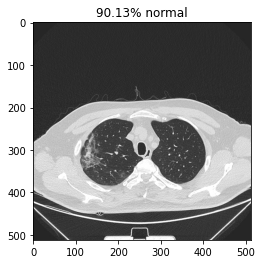

prob:[9.999304e-01 6.964912e-05]
covid/pCT101.jpg


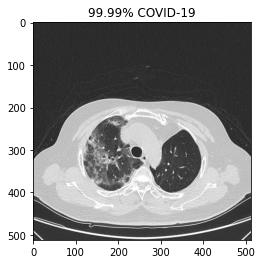

prob:[9.9999917e-01 8.8214341e-07]
covid/pCT102.jpg


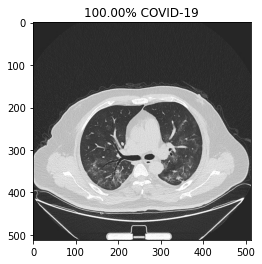

prob:[1.000000e+00 4.064945e-09]
covid/pCT103.jpg


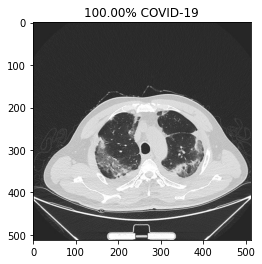

prob:[0.5790464  0.42095357]
covid/pCT104.jpg


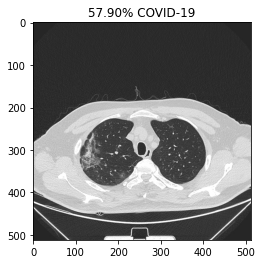

prob:[9.999218e-01 7.824530e-05]
covid/pCT105.jpg


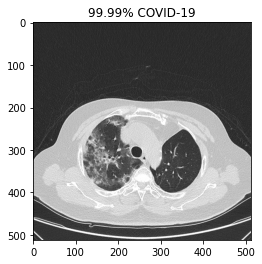

prob:[9.9999833e-01 1.7230436e-06]
covid/pCT106.jpg


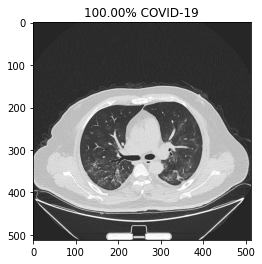

prob:[1.000000e+00 8.695376e-09]
covid/pCT107.jpg


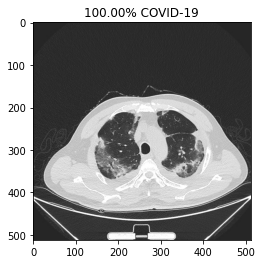

prob:[0.7014608  0.29853922]
covid/pCT108.jpg


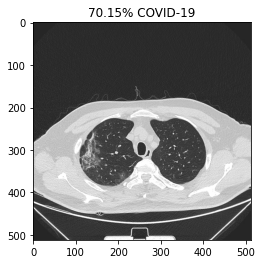

prob:[9.9981636e-01 1.8370223e-04]
covid/pCT109.jpg


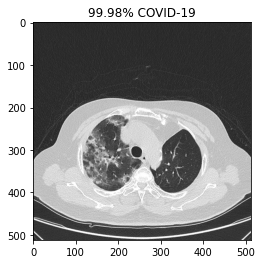

prob:[3.8909445e-07 9.9999964e-01]
covid/pCT11.jpg


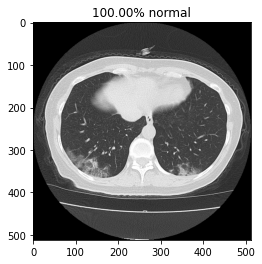

prob:[9.9999797e-01 2.0317689e-06]
covid/pCT110.jpg


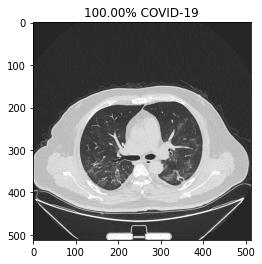

prob:[1.0000000e+00 3.5511525e-09]
covid/pCT111.jpg


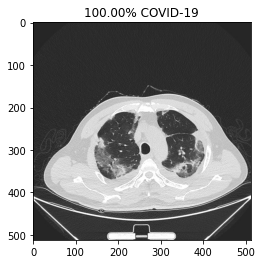

prob:[0.80462766 0.19537234]
covid/pCT112.jpg


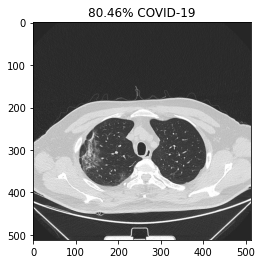

prob:[9.9995553e-01 4.4500051e-05]
covid/pCT113.jpg


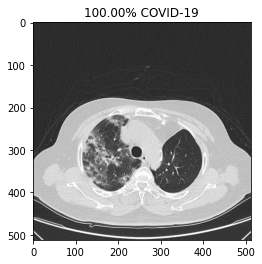

prob:[9.999974e-01 2.649586e-06]
covid/pCT114.jpg


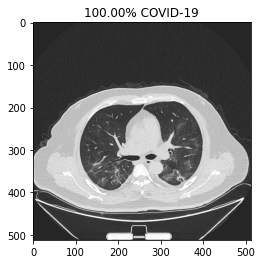

prob:[1.000000e+00 4.444748e-09]
covid/pCT115.jpg


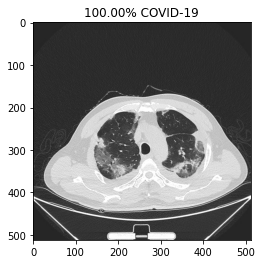

prob:[0.8746779  0.12532213]
covid/pCT116.jpg


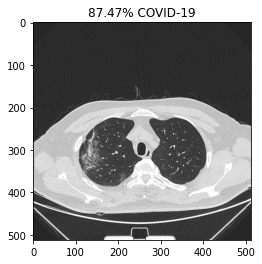

prob:[9.999602e-01 3.981604e-05]
covid/pCT117.jpg


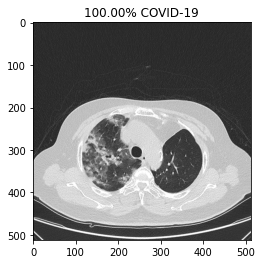

prob:[9.9999952e-01 4.8281737e-07]
covid/pCT118.jpg


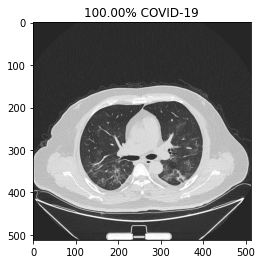

prob:[1.000000e+00 7.863173e-09]
covid/pCT119.jpg


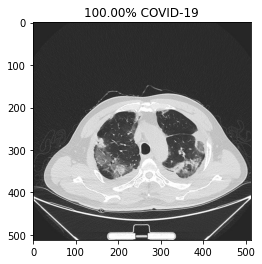

prob:[9.253885e-09 1.000000e+00]
covid/pCT12.jpg


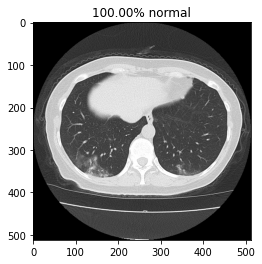

prob:[0.92525125 0.07474877]
covid/pCT120.jpg


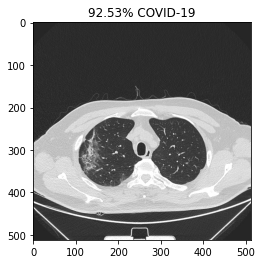

prob:[9.9995112e-01 4.8900296e-05]
covid/pCT121.jpg


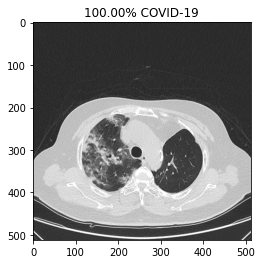

prob:[9.999994e-01 6.074946e-07]
covid/pCT122.jpg


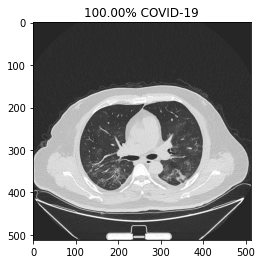

prob:[1.000000e+00 9.126104e-09]
covid/pCT123.jpg


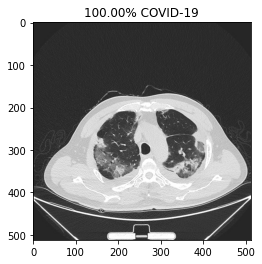

prob:[0.932685   0.06731497]
covid/pCT124.jpg


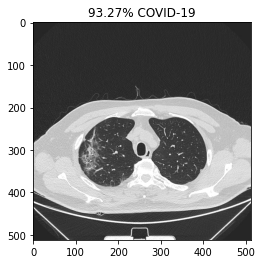

prob:[9.9997175e-01 2.8259183e-05]
covid/pCT125.jpg


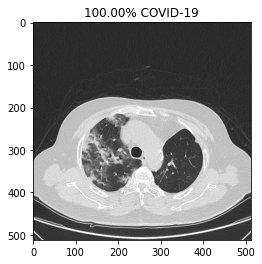

In [ ]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,30,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% normal')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [ ]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Test loss: 1.0169219970703125
Test accuracy: 0.9193548560142517


In [ ]:
import keras
from keras.models import load_model
model.save('vgg16_model_95.h5')
model_ = tf.keras.models.load_model('vgg16_model_95.h5')

In [ ]:
image_test = Image.open("/content/binary_ct/train/covid/pCT1002.jpg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

[[1.0, 6.762548658698667e-30]]

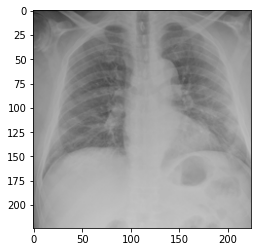

In [ ]:
plt.imshow(image_test)
model_.predict(img).tolist()

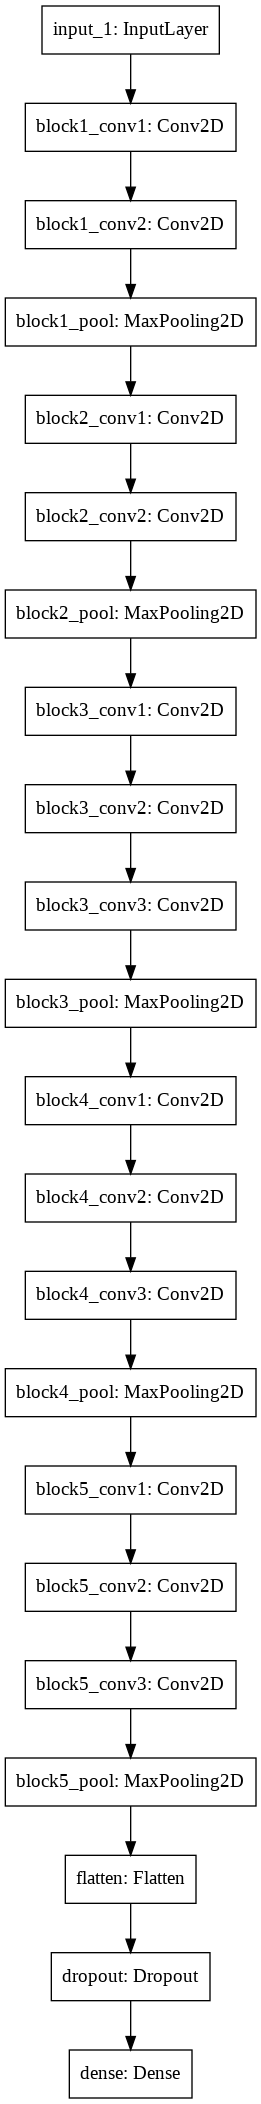

In [ ]:
from keras.utils import plot_model
plot_model(model_, to_file='model.png')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
Y_pred = model_.predict_generator(test_generator, np.ceil(len(test_generator) ))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print(confusion_matrix(test_generator.classes, y_pred))


[[468  32]
 [ 14 486]]


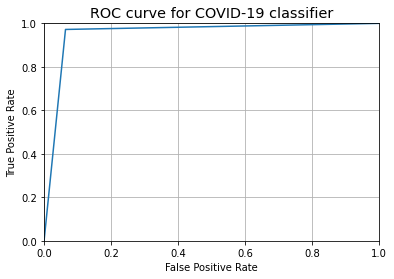

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID-19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Text(0, 0.5, 'Frequency')

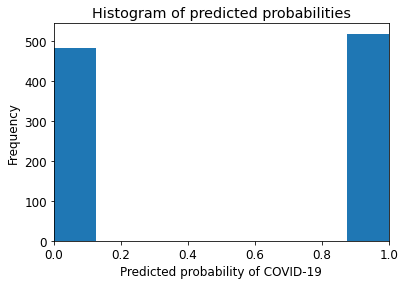

In [ ]:
plt.hist(y_pred, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of COVID-19')
plt.ylabel('Frequency')

In [ ]:
print('Classification Report')
target_names = ['COVID-19','other']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    COVID-19       0.97      0.94      0.95       500
       other       0.94      0.97      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','normal']

Confusion matrix, without normalization
[[468  32]
 [ 14 486]]


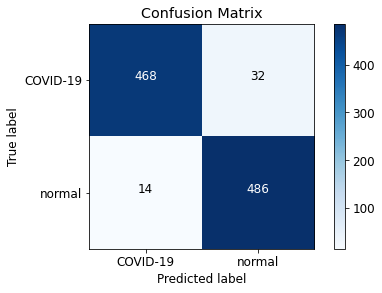

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,

                          normalize=False,

                          title=None,

                          cmap=plt.cm.Blues):


    if not title:

        if normalize:

            title = 'Normalized confusion matrix'

        else:

            title = 'Confusion matrix, without normalization'

 


    cm = confusion_matrix(y_true, y_pred)
if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")
 else:

        print('Confusion matrix, without normalization')
        print(cm)



    fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...

    ax.set(xticks=np.arange(cm.shape[1]),

           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           xticklabels=classes, yticklabels=classes,

           title=title,

           ylabel='True label',

           xlabel='Predicted label')

 

    # Rotate the tick labels and set their alignment.

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",

             rotation_mode="anchor")

 

    # Loop over data dimensions and create text annotations.

    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):

        for j in range(cm.shape[1]):

            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",

                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()

    return ax

 

 
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','other']

np.set_printoptions(precision=2)

 

# Plot non-normalized confusion matrix

plot_confusion_matrix(test_generator.classes, y_pred, target_names,

                      title='Confusion matrix, without normalization')

 

# Plot normalized confusion matrix

plot_confusion_matrix(test_generator.classes, y_pred, target_names, normalize=True,

                      title='Normalized confusion matrix')
plt.show()

SyntaxError: ignored